# 📘 Fourier Spectrum Analysis of Navier-Stokes Dataset
## Understanding Turbulent Flows using Neural Operators

This notebook analyzes the **Navier-Stokes dataset** using **Fourier Spectrum Analysis**.
We aim to visualize the energy spectrum of turbulent flow fields.

### 🔹 What is the Navier-Stokes Equation?
The **Navier-Stokes equations** describe the motion of incompressible fluid flows.
They are given by:

$$
\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} = -\nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f}
$$

where:
- $\mathbf{u}$ is the velocity field
- $p$ is the pressure field
- $\nu$ is the viscosity
- $\mathbf{f}$ is the external forcing term

In this notebook, we analyze the spectral properties of the dataset, obtained by solving these equations numerically.


In [35]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from neuralop.utils import spectrum_2d
from neuralop.data.datasets import load_navier_stokes_pt 

In [45]:
# Set font size for better visualization
font = {'size': 28}
matplotlib.rc('font', **font)
# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [46]:
# -----------------------------
# Dataset Configuration
# -----------------------------
# Define the root directory for Navier-Stokes dataset (modify as needed)
data_root = "/Users/xuhaohan/Desktop/neuraloperator-main/neuralop/data/datasets/data"  train_resolution = 128  # Spatial resolution for training data
test_resolutions = [128]  # Spatial resolution for test data
n_train = 10  # Number of training samples
n_tests = [5]  # Number of test samples
batch_size = 2  # Batch size for training
test_batch_sizes = [2]  # Batch size for testing

In [47]:
# -----------------------------
# Load the Navier-Stokes Dataset
# -----------------------------
train_loader, test_loaders, data_processor = load_navier_stokes_pt(
    n_train=n_train,
    n_tests=n_tests,
    batch_size=batch_size,
    test_batch_sizes=test_batch_sizes,
    data_root=data_root,
    train_resolution=train_resolution,
    test_resolutions=test_resolutions,
    encode_input=True,
    encode_output=True,
)

Loading test db for resolution 128 with 5 samples 


In [48]:
# -----------------------------
# Data Shape and Preprocessing
# -----------------------------
# Select a few samples to examine their shape and properties
samples = 5  # Number of samples to inspect
# Print dataset shape for validation
print("Original dataset shape:", train_loader.dataset[:samples]['x'].shape)

Original dataset shape: torch.Size([5, 1, 128, 128])


## 🔹 Why Analyze the Spectrum?

To study **turbulent flows**, we analyze the **energy spectrum** of velocity fields.

Using the **Fourier Transform**, we convert the spatial velocity field into the frequency domain, where we can observe energy distribution.

### 🔸 Energy Spectrum in Turbulent Flow

The energy spectrum is defined as:

$$ E(k) = \frac{1}{2} \sum_{\mathbf{k}} |\hat{u}(\mathbf{k})|^2 $$

where:
- $E(k)$ is the energy density at wavenumber $k$
- $\hat{u}(\mathbf{k})$ is the Fourier transform of the velocity field

By plotting $E(k)$ versus $k$, we observe how energy is distributed across different scales in the turbulent flow.


In [50]:
# Extract input dataset and remove unnecessary dimensions
# The dataset contains velocity field data from the Navier-Stokes simulation
# 'x' represents input features (e.g., vorticity field)
dataset_pred = train_loader.dataset[:samples]['x'].squeeze()  
# Extract the shape information
shape = dataset_pred.shape # Expected shape: (samples, height, width)

In [51]:
# -----------------------------
# Define Grid for Spatial Representation
# -----------------------------
# Define spatial grid dimensions
batchsize, size_x, size_y = 1, shape[1], shape[2]

# Generate a normalized 2D grid for visualization
# Grid coordinates range from -1 to 1 to standardize spatial locations
gridx = torch.tensor(np.linspace(-1, 1, size_x), dtype=torch.float)
gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, size_y])
gridy = torch.tensor(np.linspace(-1, 1, size_y), dtype=torch.float)
gridy = gridy.reshape(1, 1, size_y).repeat([batchsize, size_x, 1])

# Concatenate grid coordinates along the last dimension
grid = torch.cat((gridx, gridy), dim=-1)

# -----------------------------
# Compute 2D Spectrum of the Dataset
# -----------------------------
# Compute the energy spectrum of the dataset
# The spectrum helps analyze the frequency components of the solution
truth_sp = spectrum_2d(dataset_pred.reshape(samples * batchsize, size_x, size_y), size_x)


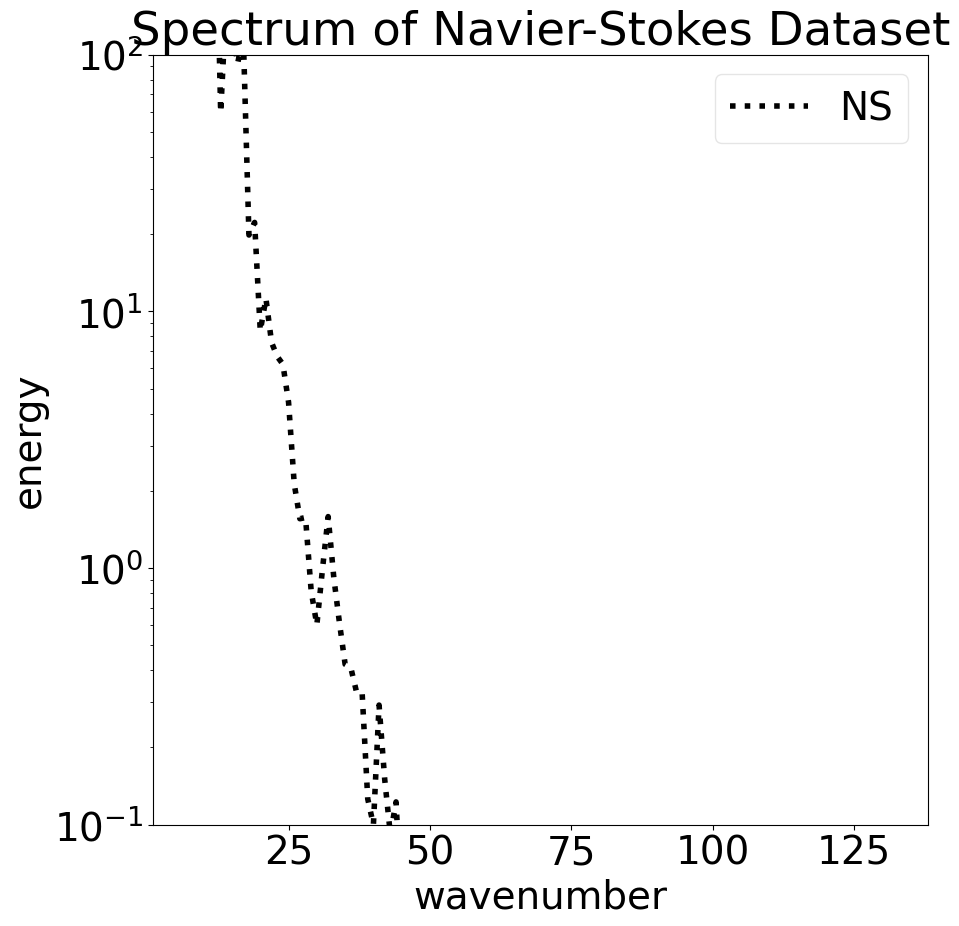

In [53]:
# -----------------------------
# Plot the Energy Spectrum
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 10))
# Set logarithmic scale for better visibility of different frequency components
ax.set_yscale('log')
# Define the wavenumber range for visualization
length = dataset_pred.shape[-1] # Get the spatial resolution of the dataset
buffer = 10 # Extra padding for visualization
k = np.arange(length + buffer) * 1.0 # Wavenumber axis

# Plot the computed energy spectrum
ax.plot(truth_sp, 'k', linestyle=":", label="NS", linewidth=4)
ax.set_xlim(1, length + buffer) # Set x-axis and y-axis limits
ax.set_ylim(0.1, 100)

# Configure legend and labels
plt.legend(prop={'size': 20})
plt.title('Spectrum of Navier-Stokes Dataset')
plt.xlabel('wavenumber')
plt.ylabel('energy')

# Improve legend transparency for clarity
leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.show()

# Analysis of the Spectrum of Navier-Stokes Dataset

The plot represents the energy spectrum $E(k)$ of the Navier-Stokes dataset, where $k$ is the wavenumber. The energy distribution follows a power-law decay:
$$
E(k) \propto k^{-\alpha}
$$
### **Observations:**
- The spectrum shows a clear **energy cascade**, where large scales (low $k$) contain more energy, and smaller scales (high $k$) experience dissipation.
- The log-log plot suggests a **power-law scaling**, consistent with Kolmogorov's turbulence theory, which predicts $E(k) \sim k^{-5/3} $ in the inertial range.
- The sharp drop at high $k$ indicates **numerical dissipation** due to finite resolution.

### **Conclusion:**
This spectrum confirms that the dataset captures key turbulence features.